## TED Talk Dataset EDA

### Merge main data frame with transcripts

In [1]:
import pandas as pd

In [2]:
df_main = pd.read_csv("tedtalks/ted_main.csv")
df_transcripts = pd.read_csv("tedtalks/transcripts.csv")

Notice there are 2550 rows in the main file, but only 2467 of them have transcripts.

In [3]:
len(df_main), len(df_transcripts)

(2550, 2467)

Merge data frames on `url`, since some ted talks in `ted_main.csv` do not have transcripts in `transcripts.csv`.

In [4]:
df_merged = df_main.merge(df_transcripts, how="inner", on="url")

### Extract most popular rating class for each TED talk

First replace single quotation marks with double quotation marks so that ratings is in appropriate JSON format

In [5]:
df_merged["ratings"] = df_merged["ratings"].apply(lambda ratings: ratings.replace('\'', '\"'))

Now create a new column `highest_rating` with the category that has the most votes for a given TED talk, e.g. Inspiring, Funny, Informative etc.

In [6]:
import json

In [7]:
def extract_highest_rating(ratings_json):
    """ For a set of ratings for a TED talk in JSON format, 
        extract the category with the most votes,
        e.g. Inspiring, Funny, Informative etc."""
    
    # 1. Read JSON into pandas data frame
    ratings_df = pd.read_json(ratings_json)
    
    # 2. Extract index with most votes
    max_index = ratings_df["count"].argmax()
    
    # 3. Return category with most votes
    return ratings_df.iloc[max_index]["name"]

In [8]:
df_merged['highest_rating'] = df_merged["ratings"].apply(extract_highest_rating)

 View distribution of `highest_rating`

In [9]:
import matplotlib.pyplot as plt

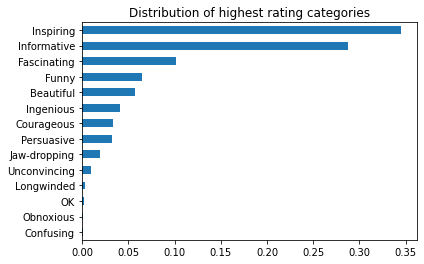

In [10]:
(df_merged['highest_rating'].value_counts()/len(df_merged)).sort_values().plot.barh()
plt.title("Distribution of highest rating categories");

Baseline accuracy (just predicting most popular class) would be 34.5%

In [11]:
baseline_acc = df_merged['highest_rating'].value_counts().max()/len(df_merged)
round(baseline_acc, 4) * 100

34.5

### Counts of keywords

In [12]:
from collections import defaultdict
tag_counts = defaultdict(int)
for tags in df_merged["tags"]:
    for tag in eval(tags):
        tag_counts[tag] += 1

In [13]:
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=["Keyword", "Count"])
tag_counts_df = tag_counts_df.sort_values('Count', ascending = False)

<BarContainer object of 11 artists>

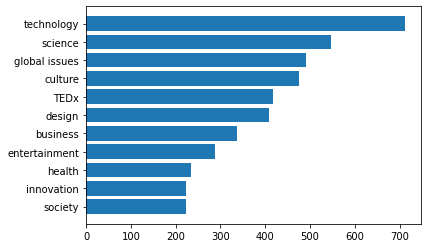

In [14]:
plt.barh(y=tag_counts_df["Keyword"][10::-1], width=tag_counts_df["Count"][10::-1])

### Extract TED category for each TED talk

This involves finding which of Technology, Entertainment or Design a given TED talk corresponds to, 
based on its keywords.

In [15]:
def extract_category(tags):
    """ Given a string containing a list of tags, 
        returns its TED category.
        
        Sample input: "['computers', 'entertainment', 'technology']"
        Sample output: ['technology', 'entertainment']
    """
    category_options = ['technology', 'entertainment', 'design']
    
    tags = eval(tags) # Cast from e.g. "['a', 'b']" to ['a', 'b']
    tags = [tag.lower() for tag in tags] # Cast all tags to lower case
    
    category = set(category_options).intersection(tags)
    
    return sorted(list(category), reverse = True) # Descending order means tech then entertainment then design (i.e. TED order)

In [16]:
df_merged['category'] = df_merged["tags"].apply(extract_category)

In [47]:
def plot_y_distribution(df, percentages=False):
    if percentages:
        (df['category'].value_counts()/len(df)).sort_values().plot.barh()
    else:
        df['category'].value_counts().sort_values().plot.barh()
    plt.title("Distribution of categories")

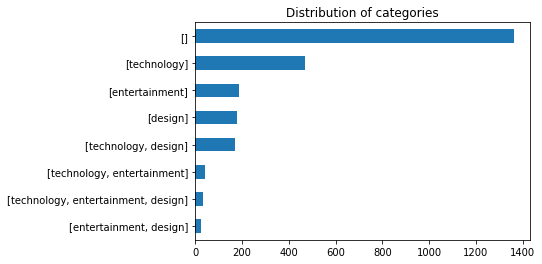

In [48]:
plot_y_distribution(df_merged)

Baseline accuracy (just predicting most popular class) would be 55.25%

In [18]:
baseline_acc = df_merged['category'].value_counts().max()/len(df_merged)
round(baseline_acc, 4) * 100

55.25

### Train-val-test split

In [25]:
df_all = df_merged[["transcript", "category"]]
df_all

,transcript,category
0,Good morning. How are you?(Laughter)It's been ...,[]
1,"Thank you so much, Chris. And it's truly a gre...",[technology]
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...","[technology, entertainment]"
3,If you're here today — and I'm very happy that...,[]
4,"About 10 years ago, I took on the task to teac...",[]
...,...,...
2462,"So, Ma was trying to explain something to me a...",[]
2463,This is a picture of a sunset on Mars taken by...,[]
2464,"In my early days as a graduate student, I went...",[]
2465,I took a cell phone and accidentally made myse...,[]


In [52]:
from sklearn.model_selection import train_test_split

# Constants
RANDOM_STATE = 42
VALIDATION_SET_SIZE = 250
TEST_SET_SIZE = 250

df_train, df_test = train_test_split(df_all, 
                                     test_size=TEST_SET_SIZE,
                                     random_state=RANDOM_STATE,
                                     stratify=df_all["category"])
df_train, df_val = train_test_split(df_train, 
                                    test_size=VALIDATION_SET_SIZE,
                                    random_state=RANDOM_STATE,
                                    stratify=df_train["category"])

len(df_train), len(df_val), len(df_test)

(1967, 250, 250)

### Explore data

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [70]:
sample_texts = list(df_all["transcript"])

In [71]:
get_num_words_per_sample(sample_texts)

2028.0

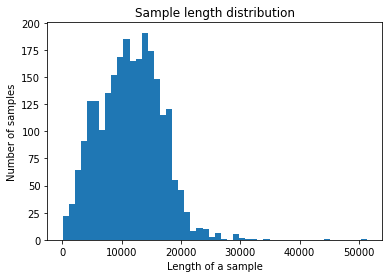

In [73]:
plot_sample_length_distribution(sample_texts) # Length in characters